##  Neural Networks vs. Tree-Based Models for Tabular Data


### Abstract: 
Implementation of three different models including a simple neural network with a single hidden layer, XGBoost and a random forest. The data is taken from the Kaggle and can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. The dataset comprises of about 1461 observations and 81 features in the train data and 1459 observations and 80 features in the test data. Will be predicting the SalePrice of the houses. The test data does not incldue the labels.  

## Getting and Understanding the Data

Installing and importing required libraries

In [ ]:
! pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 457 kB/s 
     |████████████████████████████████| 9.9 MB 25.1 MB/s 
     |████████████████████████████████| 15.7 MB 50.0 MB/s 
     |████████████████████████████████| 61 kB 7.8 MB/s 
     |████████████████████████████████| 11.2 MB 43.9 MB/s 
     |████████████████████████████████| 120 kB 47.1 MB/s 
     |████████████████████████████████| 960 kB 21.9 MB/s 
     |████████████████████████████████| 1.6 MB 46.6 MB/s 
     |████████████████████████████████| 82 kB 768 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: panda

In [ ]:
!printf 'y\n' | pip uninstall matplotlib
!pip install --upgrade matplotlib

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)?   Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
ERROR: pip's dependency resolver does not currently take into

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
from d2l import torch as d2l

Downloading housing price prediction data using a user-defined function.

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')): 
    """Download a file inserted into DATA_HUB, return the local filename."""
    # check to see if the file has been downloaded
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    # if name in DATA_HUB get the associated tuple
    url, sha1_hash = DATA_HUB[name]
    # make a new dir if none exists otherwise, do nothing
    os.makedirs(cache_dir, exist_ok=True)
    #grab the filename off the url, join to dir and assign to fname
    fname = os.path.join(cache_dir, url.split('/')[-1])
    # check to see if the file is there
    if os.path.exists(fname):
        # create a sha1 has object
        sha1 = hashlib.sha1()
        # open the file and read as bytes
        with open(fname, 'rb') as f:
            while True:
                # read in file upto 1mb
                data = f.read(1048576)
                # if no data then exit
                if not data:
                    break
                # creates a sha1 has
                sha1.update(data)
        # check to see if there's a match
        if sha1.hexdigest() == sha1_hash: 
            return fname  # Hit cache
    # notify of download
    print(f'Downloading {fname} from {url}...')
    # get the data
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
        
    return fname


In [ ]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    # call the above download function
    fname = download(name)
    # get the directory where the file is located
    base_dir = os.path.dirname(fname)
    # get dir and fname without extension
    data_dir, ext = os.path.splitext(fname)
    # test if ext is zip
    if ext == '.zip':
        #if it is then unzip
        fp = zipfile.ZipFile(fname, 'r')
    # test if .tar or .gz
    elif ext in ('.tar', '.gz'):
        #if it is then open
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    # extract all the files
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): 
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [ ]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
df_tr = pd.read_csv(download('kaggle_house_train'))
df_ts = pd.read_csv(download('kaggle_house_test'))

Understanding the downloaded data.

In [ ]:
df_tr.shape

(1460, 81)

In [ ]:
df_ts.shape

(1459, 80)

In [ ]:
df_tr.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
df_ts.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
df_tr.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [ ]:
df_tr.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


Dropping the 'Id' column from the train and test dataset.

In [ ]:
# combine train (without index and salesprice) and text (without index --no salesprice here)
df_all = pd.concat([df_tr.iloc[:, 1:-1], df_ts.iloc[:, 1:]])

## Data Preprocessing

We will be scaling numerical data to make it standard. The categorical features will be one-hot encoded using get_dummies method. This pre-processed data will be used for all the models built.

In [ ]:
# get all numeric features
index_num_features = df_all.dtypes[df_all.dtypes != 'object'].index

We standardize the numerical data by subtracting the mean from the values and dividing by the standard deviation:  $\frac{x - \bar{x}}{\sigma}$

In [ ]:
# standardize the numeric data  
df_all[index_num_features] = df_all[index_num_features].apply(lambda x: (x - x.mean())/(x.std()))

In [ ]:
# fill in the na's with 0
df_all[index_num_features] = df_all[index_num_features].fillna(0)

In [ ]:
df_all.shape

(2919, 79)

Encoding the categorical columns.

In [ ]:
# convert categorical variables to dummies
df_all = pd.get_dummies(df_all, dummy_na=True)

In [ ]:
df_all.shape

(2919, 331)

In [ ]:
# get the training rows from the converted dataframe
int_train_rows = df_tr.shape[0]

In [ ]:
# creates a torch matrix (1460, 331)
tensor_tr_features = (torch.tensor(df_all.iloc[:int_train_rows].values, dtype=torch.float32))
# creates a torch matrix (1459, 331)
tensor_ts_features = (torch.tensor(df_all.iloc[int_train_rows:].values, dtype=torch.float32))

In [ ]:
# reshapes the training data salesprince from (1460,) to (1460,1)
tensor_tr_labels = torch.tensor(df_tr.SalePrice.values.reshape(-1,1), dtype=torch.float32)

In [ ]:
tensor_tr_features.shape

torch.Size([1460, 331])

## Model 1: Neural Network

Here we will be doing the following:

-  Creating functions to define the neural net, the loss function, and train.
- We use a simple neural network with just one hidden layer and we use ReLu as the activation function. 
- The loss that is used is the log of root mean squared error. 

In [ ]:
# define the loss function
loss = nn.MSELoss()
# get the number of features in the training data
int_tr_features = tensor_tr_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(int_tr_features, 64),
                        nn.ReLU(),
                        # output layer
                        nn.Linear(64, 1)
                        )
    return net

# def get_net():
#     net = nn.Sequential(nn.Linear(int_tr_features, 64),
#                         nn.ReLU(),
#                         nn.Linear(64,  32),
#                         nn.ReLU(),
#                         # output layer
#                         nn.Linear(32, 1)
#                         )
#     return net


# def get_net():
#     net = nn.Sequential(nn.Linear(int_tr_features, 1))
#     return net

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md

In [ ]:
def log_rmse(net, features, labels):
    # To further stablize the value when the logarithm is taken, set
    # the value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

Here the Adam optimizer method from the torch.optim class is used to optimize the weights and biases of the neural network. This function returns the train and the test losses.

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_deacy, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels),batch_size)
    # the Adam optimization is used here
    optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate,
                                 weight_decay=weight_deacy)
    
    # iterate through the epochs
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### K-Fold Cross-Validation for the neural network model

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # calcualte the size of the fold
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}'
              )
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.055959, valid log rmse 0.151505
fold 2, train log rmse 0.112516, valid log rmse 0.227065
fold 3, train log rmse 0.067134, valid log rmse 0.155686
fold 4, train log rmse 0.095724, valid log rmse 0.131398
fold 5, train log rmse 0.069944, valid log rmse 0.159429
5-fold validation: avg train log rmse: 0.080255, avg valid log rmse: 0.165016


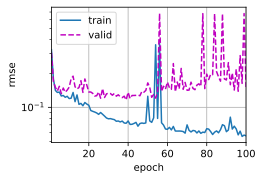

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, tensor_tr_features, tensor_tr_labels, num_epochs, lr,
                          weight_decay, batch_size)

print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
f'avg valid log rmse: {float(valid_l):f}')

The neural network model results in an average log rmse score of 0.080 for the train data and an average log rmse score of 0.165 for the validation data. We will be comparing this score with the log rmse scores from the other models.  

## Model 2: XGBoost with Sci-kit Learn

In [ ]:
# importing required libraries
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [ ]:
type(df_all)

pandas.core.frame.DataFrame

In [ ]:
n_train = df_tr.shape[0]
n_train

1460

In [ ]:
# Creating training and test data variables
X_train = df_all[:n_train]
X_train.shape

(1460, 331)

In [ ]:
X_test = df_all[n_train:]
X_test.shape

(1459, 331)

In [ ]:
Y_train = df_tr['SalePrice']
Y_train.shape

(1460,)

In [ ]:
Y_train

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

Splitting the train data into train and validation sets as we do not have the labels for the test data here. 


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42) 

In [ ]:
def XGBoost(xtrain,ytrain,xtest):
  xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
  xgb_model.fit(xtrain, ytrain)
  y_pred = xgb_model.predict(xtest)
  return y_pred

In [ ]:
y_pred_train = XGBoost(x_train, y_train, x_train)
y_pred_val = XGBoost(x_train,y_train, x_val)

In [ ]:
y_pred_train

array([143299.06 , 176250.92 ,  97041.22 , ..., 123951.664, 171698.94 ,
       189654.45 ], dtype=float32)

Log root mean squared error is calculated using the mean_squared_log_error of scikit-learn metrics class.

In [ ]:
lmse_train = mean_squared_log_error(y_train, y_pred_train)
print(lmse_train)
lmse_val = mean_squared_log_error(y_val, y_pred_val)
print(lmse_val)

0.00781888387407571
0.020498468539549463


#### Cross-validation using the GridSearchCV method.

The best model parameters are chosen and the best model is used to find the log mean squared error. 

In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True, 
                        )
#scoring = 'neg_mean_squared_log_error'
xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.8562079131440541
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [ ]:
lmse_train_best = mean_squared_log_error(y_train, xgb_grid.best_estimator_.predict(x_train))
lmse_val_best =  mean_squared_log_error(y_val, xgb_grid.best_estimator_.predict(x_val))

print("Log RMSE score on the train data for the best model:", round(lmse_train_best,5))
print("Log RMSE score on the validation data for the best model:", round(lmse_val_best,5))

Log RMSE score on the train data for the best model: 0.00116
Log RMSE score on the validation data for the best model: 0.01854


The log root mean squared error on the train data is 0.00116  and validation data is 0.01854 for XGBoost.

## Model 3: Random Forest with Sci-kit Learn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
rf = RandomForestRegressor()

We will use the same train and validation data used in the XGBoost case.

In [ ]:
rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
lmse = mean_squared_log_error(y_train, y_pred_train)
lmse

0.0035976425593957874

We perform the cross-validation using GridSearchCV method to find the best model parameters.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 105, 110, 115,],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
rf_grid = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3, 
                           n_jobs = -1,
                           verbose = 2)

In [ ]:
# Fit the grid search to the data
rf_grid.fit(x_train,y_train)
rf_grid.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

In [ ]:
lmse_best_train = mean_squared_log_error(y_train, rf_grid.best_estimator_.predict(x_train))
lmse_best_val = mean_squared_log_error(y_val, rf_grid.best_estimator_.predict(x_val))

In [ ]:
print("Log RMSE score on the train data for the best model:", round(lmse_best_train,6))
print("Log RMSE score on the validation data for the best model:", round(lmse_best_val,6))

Log RMSE score on the train data for the best model: 0.049034
Log RMSE score on the validation data for the best model: 0.072599


The log rmse score for the best random forest model is 0.043356 for the train data and 0.0726 for the validation data.


The log rmse scores obtained from the tree models for the train data are:

1. Neural network: 0.080255
2. XGBoost: 0.00116
3. Random Forest: 0.049034

The log rmse scores obtained from the tree models for the validation data are:

1. Neural network: 0.165016
2. XGBoost: 0.01854
3. Random Forest: 0.072599

Based on the train and the validation scores, we can see that the tree-based models such as Random forest and XGBoost does better than a simple neural network with a single hidden layer. In this case, XGBoost performs the best with a validation log rmse score of 0.01854. 